In [1]:
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
from matplotlib import pyplot
from mlxtend.feature_selection import SequentialFeatureSelector as sfbs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfbs
from numpy import *
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from numpy.random import seed
from pandas import read_csv
from random import randint
from random import random
from random import seed
from scipy import stats # For in-built method to get PCC
from sklearn import linear_model
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.stats.outliers_influence import OLSInfluence
from tqdm import tnrange, tqdm_notebook
from zca import zca
import itertools
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import pingouin as pg
import scipy
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys

#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")
#import random
import warnings
warnings.filterwarnings('ignore')

y_train_scaler = StandardScaler()
x_train_inter_scaler = StandardScaler()
zca = zca.ZCA()

In [2]:
class ss_yj_Transformer(BaseEstimator, TransformerMixin):
    # add another additional parameter, just for fun, while we are at it
    
    def __init__(self, feature_names=[], additional_param = ""):  
        #print('\n>>>>>>>init() called.\n')
        self.ss = StandardScaler()
        self.pt = PowerTransformer(standardize=False)
        self.feature_names = feature_names
        self.additional_param = additional_param

    def fit(self, X, y = None):
        self.ss.fit(X)
        self.pt.fit(self.ss.transform(X))
        return self

    def transform(self, X, y = None):
        pt_X_ = pd.DataFrame(self.pt.fit(pd.DataFrame(self.ss.fit(X).transform(X),index=X.index,columns=X.columns)).transform(pd.DataFrame(self.ss.fit(X).transform(X),index=X.index,columns=X.columns)),index=X.index,columns=X.columns)
        return pt_X_

    def inverse_transform(self, target):
        target_ = pd.DataFrame(self.ss.inverse_transform(self.pt.inverse_transform(target)),index=target.index,columns=target.columns)
        return target_

In [3]:
numCV = 5
kfold = KFold(n_splits=numCV, shuffle=True)
p_threshold = .05
divisor = .2
target = 'Poverty'
exclude = 'States'

cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
l1s = arange(0, 1, 0.01/divisor)

seed_ = 3

#random.seed(11)

seed(seed_)

In [4]:
# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()

In [5]:
all_data = pd.read_csv('../data/raw/states.csv')

In [14]:

train, valid = train_test_split(all_data.index, test_size=0.3, shuffle=True)
valid, test = train_test_split(valid,  test_size=0.5, shuffle=True)

X = all_data[set(all_data.columns).difference([target,exclude])].copy()
y = pd.DataFrame(all_data[target].copy())

X_train = X.loc[train].copy()
X_valid = X.loc[valid].copy()
X_test = X.loc[test].copy()

y_train = y.loc[X_train.index][[target]].copy()
y_valid = y.loc[X_valid.index][[target]].copy()
y_test = y.loc[X_test.index][[target]].copy()

X_train_ss_yj_t = ss_yj_Transformer()
X_train_ss_yj_t.fit(X_train)
X_train_ss_yj = X_train_ss_yj_t.transform(X_train)

y_train_ss_yj_t = ss_yj_Transformer()
y_train_ss_yj_t.fit(y_train)
y_train_ss_yj = y_train_ss_yj_t.transform(y_train)

#y_train_scaler.fit(np.array(y_train).reshape(-1, 1))

#pd.DataFrame([i[0] for i in scaler.transform(np.array(y_train).reshape(-1, 1))])

array([[<AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Infant Mort'}>,
        <AxesSubplot:title={'center':'Crime'}>],
       [<AxesSubplot:title={'center':'White'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'University'}>],
       [<AxesSubplot:title={'center':'Unemployed'}>,
        <AxesSubplot:title={'center':'Traf Deaths'}>,
        <AxesSubplot:title={'center':'Doctors'}>]], dtype=object)

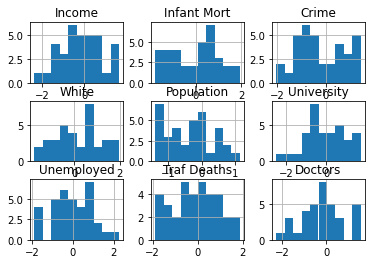

In [13]:
X_train_ss_yj.hist()

array([[<AxesSubplot:title={'center':'Poverty'}>]], dtype=object)

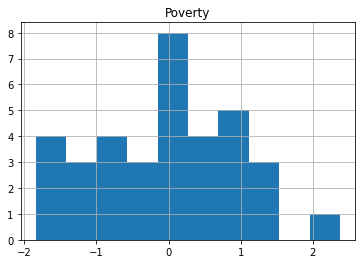

In [ ]:
ss_X_train = StandardScaler()
ss_X_train_scale_fit = ss_X_train.fit(X_train)
ss_X_train_fit = ss_X_train_scale_fit.transform(X_train)
print(ss_X_train_scale_fit.scale_)
print(ss_X_train_scale_fit.mean_)

pt = PowerTransformer(standardize=False)
pt_X_train_fit = pt.fit(ss_X_train_fit)
print(pt_X_train_fit.lambdas_)
pt_X_train = pd.DataFrame(pt_X_train_fit.transform(ss_X_train_fit),index=X_train.index,columns=X_train.columns)
#inverse
#pd.DataFrame(ss_X_train_fit.inverse_transform(pt_X_train_fit.inverse_transform(pt_X_train)),index=X_train.index,columns=X_train.columns)


In [ ]:
ss_y_train = StandardScaler()
ss_y_train_scale_fit = ss_y_train.fit(y_train)
ss_y_train_fit = ss_y_train_scale_fit.transform(y_train)
print(ss_y_train_scale_fit.scale_)
print(ss_y_train_scale_fit.mean_)

pt = PowerTransformer(standardize=False)
pt_y_train_fit = pt.fit(ss_y_train_fit)
print(pt_y_train_fit.lambdas_)
pt_y_train = pd.DataFrame(pt_y_train_fit.transform(ss_y_train_fit),index=y_train.index,columns=y_train.columns)

In [ ]:
import sklearn
from sklearn.preprocessing import *

interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

x_train_inter = pd.DataFrame(interaction.fit_transform(pt_X_train),index=pt_X_train.index,columns=interaction.get_feature_names(input_features=pt_X_train.columns))

In [ ]:
lr = LinearRegression()

#backwards step subset
sfbs1 = sfbs(lr, 
          k_features=len(x_train_inter.columns), 
          #forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=numCV)
            
sfbs1 = sfbs1.fit(x_train_inter, pt_y_train)


In [ ]:
fig = plot_sfbs(sfbs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
features = list(pd.DataFrame(sfbs1.subsets_).loc['feature_names'].values)

In [ ]:
ss_position = np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']).argmax()

In [ ]:
ss_position_parse = list((pd.DataFrame(sfbs1.subsets_)).T[(pd.DataFrame(sfbs1.subsets_)).T['avg_score']>=np.max(np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']))-np.std(np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']))]['feature_names'].iloc[0])

In [ ]:
ss_position_parse

In [ ]:
ss_sortedFeatures = list(np.array(pd.DataFrame(sfbs1.subsets_).loc['feature_names'])[ss_position])

In [ ]:
CV_results = pd.DataFrame()#[]#np.zeros(shape=(len(features),5))

#looping over sequentially selected features, deriving ElasticNet hyper parm's over each best subset and noting error

for f in features:

    print(f)
    cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

    EN_CV = ElasticNetCV(l1_ratio=l1s, alphas=alphas, cv=cv, n_jobs=-1)
    # fit model

    X_subset = pd.DataFrame(x_train_inter[list(np.asarray(f))])
    y_ = pt_y_train
    EN_CV.fit(X_subset, y_)
    
    print('alpha: %f' % EN_CV.alpha_)
    print('l1_ratio_: %f' % EN_CV.l1_ratio_)
    
    # evaluate model
    scores = cross_val_score(EN_CV, X_subset, y_, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    temp = pd.concat([pd.DataFrame({"features": [np.array(f)]}),pd.DataFrame(np.array(mean(scores)).reshape(-1,1)),pd.DataFrame(np.array(std(scores)).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.alpha_).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.l1_ratio_).reshape(-1,1))],axis=1)
    
    CV_results = pd.concat([CV_results,temp],axis=0)

In [ ]:
CV_results.columns = ['features','mean error','std','alpha','lambda']
CV_results.index = np.array(range(0,len(features)))#range(1,len(features)+1)
plt.plot(CV_results['mean error'])
plt.show()

best = CV_results.iloc[CV_results['mean error'].idxmin()]
print(best.loc['features'])

parse = CV_results[CV_results['mean error']<=(np.min(CV_results['mean error'])+np.std(CV_results['mean error']))].iloc[0]
print(parse.loc['features'])
display(CV_results)

In [ ]:
ss_sortedFeatures

In [ ]:
model_ss = LinearRegression()
model_ss_parse = LinearRegression()
model_ep = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])
model_eb = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

model_ss.fit(x_train_inter[ss_sortedFeatures], pt_y_train)
model_ss_parse.fit(x_train_inter[ss_position_parse], pt_y_train)
model_ep.fit(x_train_inter[parse['features']],pt_y_train)
model_eb.fit(x_train_inter[best['features']],pt_y_train)

In [ ]:
zca_X_train = pd.DataFrame(zca.fit_transform(x_train_inter[ss_position_parse]),columns=ss_position_parse,index=x_train_inter.index)
zca_X_train.index = x_train_inter.index
#zca_data = pd.concat([pt_y_train,zca_X_train],axis=1)
#zca_data.index = x_train_inter.index

In [ ]:
pca_X_train = PCA(n_components=0.99, svd_solver='full')
pca_X_train.fit(x_train_inter[ss_sortedFeatures])
X_pca_train = pd.DataFrame(pca_X_train.transform(x_train_inter[ss_sortedFeatures]),index = x_train_inter.index)

In [ ]:
#zca_data.pcorr()

In [ ]:
#sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [ ]:
pca_X_train.explained_variance_ratio_.cumsum()

In [ ]:
len(ss_sortedFeatures)

In [ ]:
#model = sklearn.linear_model.LinearRegression()
#data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
data_set_wConstant_parse = statsmodels.tools.tools.add_constant(zca_X_train)
#y_ = data_set_wConstant[target]
#data_set_wConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model_parse = sm.OLS(pt_y_train,data_set_wConstant_parse)
results_parse = model_parse.fit()
fitted_parse = results_parse.predict(data_set_wConstant_parse)
results_parse.summary()

In [ ]:
linear_plot = Plot.LinearRegressionResidualPlot(data_set_wConstant_parse.values, pt_y_train.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

In [ ]:
pd.DataFrame(results_parse.get_influence().resid_studentized_internal).hist()

In [ ]:
print(ss_sortedFeatures)

In [ ]:
#model = sklearn.linear_model.LinearRegression()
#data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
data_set_wConstant = statsmodels.tools.tools.add_constant(X_pca_train)
#y_ = data_set_wConstant[target]
#data_set_wConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(pt_y_train,data_set_wConstant)
results = model.fit()
fitted = results.predict(data_set_wConstant)
results.summary()

In [ ]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

In [ ]:
linear_plot = Plot.LinearRegressionResidualPlot(data_set_wConstant.values, pt_y_train.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))


In [ ]:
#
y_train_original = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(pt_y_train)),index=y_train.index,columns=y_train.columns)
y_train_predicted = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(np.array(results.fittedvalues).reshape(-1,1))),index=y_train.index,columns=y_train.columns)

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))

y_valid_ss_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_ss.predict(temp_valid[ss_sortedFeatures]))),index=y_valid.index,columns=[target])
# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid-y_valid_ss_fitted)))

#temp = pd.concat([y_train_predicted,y_train_original],axis=1)
temp = pd.concat([y_valid_ss_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [ ]:
#model_Best = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

ENBestResults = model_eb.fit(x_train_inter[best['features']], pt_y_train)

ENBestFitted = pd.DataFrame(model_eb.predict(x_train_inter[best['features']]),index=x_train_inter.index, columns = [target])

y_train_original = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(pt_y_train)),index=y_train.index,columns=y_train.columns)
y_train_predicted = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(np.array(ENBestFitted).reshape(-1,1))),index=y_train.index,columns=y_train.columns)

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))

y_valid_eb_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(np.array(model_eb.predict(temp_valid[best['features']]).reshape(-1,1)))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_eb_fitted-y_valid)))

temp = pd.concat([y_valid_eb_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [ ]:
#model_Parse = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])

ENParseResults = model_ep.fit(x_train_inter[parse['features']], pt_y_train)

ENParseFitted = pd.DataFrame(model_ep.predict(x_train_inter[parse['features']]),index=x_train_inter.index,columns=[target])

y_train_original = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(pt_y_train)),index=y_train.index,columns=y_train.columns)
y_train_predicted = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(np.array(ENParseFitted).reshape(-1,1))),index=y_train.index,columns=y_train.columns)

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))

y_valid_ep_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(np.array(model_ep.predict(temp_valid[parse['features']]).reshape(-1,1)))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_ep_fitted-y_valid)))

temp = pd.concat([y_valid_ep_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [ ]:
y_valid_rr_ss_fitted=y_valid

In [ ]:
#robust regression using ss
# define the model
model_rr_ss = RANSACRegressor()
# evaluate model
Rresults_ss = evaluate_model(x_train_inter[ss_sortedFeatures], pt_y_train, model_rr_ss)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_ss), std(Rresults_ss)))
# plot the line of best fit
Rresults_ss = model_rr_ss.fit(x_train_inter[ss_sortedFeatures],pt_y_train)
RFitted_ss = model_rr_ss.predict(x_train_inter[ss_sortedFeatures])

temp_all = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X)),index=X.index,columns=X.columns)),index=X.index,columns=interaction.get_feature_names(input_features=X.columns))
RFitted_ss_all = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_ss.predict(temp_all[ss_sortedFeatures])))

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))
y_valid_rr_ss_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_ss.predict(temp_valid[ss_sortedFeatures]))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_ss_fitted-y_valid)))

temp = pd.concat([y_valid_rr_ss_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [ ]:

#robust regression using best
# define the model
model_rr_best = RANSACRegressor()
# evaluate model
Rresults_best = evaluate_model(x_train_inter[best['features']], pt_y_train, model_rr_best)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_best), std(Rresults_best)))
# plot the line of best fit
Rresults_best = model_rr_best.fit(x_train_inter[best['features']],pt_y_train)
RFitted_best = model_rr_best.predict(x_train_inter[best['features']])

temp_all = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X)),index=X.index,columns=X.columns)),index=X.index,columns=interaction.get_feature_names(input_features=X.columns))
RFitted_best_all = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_best.predict(temp_all[best['features']])))

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))
y_valid_rr_best_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_best.predict(temp_valid[best['features']]))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_best_fitted-y_valid)))

temp = pd.concat([y_valid_rr_best_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [ ]:

#robust regression using best
# define the model
model_rr_parse = RANSACRegressor()
# evaluate model
Rresults_parse = evaluate_model(x_train_inter[best['features']], pt_y_train, model_rr_parse)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_parse), std(Rresults_parse)))
# plot the line of best fit
Rresults_parse = model_rr_parse.fit(x_train_inter[parse['features']],pt_y_train)
RFitted_parse = model_rr_parse.predict(x_train_inter[parse['features']])

temp_all = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X)),index=X.index,columns=X.columns)),index=X.index,columns=interaction.get_feature_names(input_features=X.columns))
RFitted_parse_all = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_parse.predict(temp_all[parse['features']])))

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))
y_valid_rr_parse_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_parse.predict(temp_valid[parse['features']]))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_parse_fitted-y_valid)))

temp = pd.concat([y_valid_rr_parse_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [ ]:
temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))
y_valid_ss_fitted = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_ss.predict(temp_valid[ss_sortedFeatures])))
y_valid_eb_fitted = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_eb.predict(temp_valid[best['features']]).reshape(-1, 1)))
y_valid_ep_fitted = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_ep.predict(temp_valid[parse['features']]).reshape(-1, 1)))

In [ ]:
print("OLS SS: " + str(mean(absolute(np.array(y_valid)-y_valid_ss_fitted))))
print("EN best: " + str(mean(absolute(np.array(y_valid)-y_valid_eb_fitted))))
print("EN parse: " + str(mean(absolute(np.array(y_valid)-y_valid_ep_fitted))))

print("RR SS: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_ss_fitted))))
print("RR best: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_best_fitted))))
print("RR parse: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_parse_fitted))))

In [ ]:
print("RR parse: " + str(mean(absolute(np.array(y)-RFitted_parse_all))))
print("RR ss: " + str(mean(absolute(np.array(y)-RFitted_ss_all))))